In [10]:
import os, os.path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import matplotlib.patches as patches
import glob
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
from torch import nn,  Tensor
import torch.optim as optim

## Data Loading

In [2]:
def load_data(folder = "../backend-project/data/", filenames_to_keep=None):
    '''
    Load the data about each image, the names of the images used for training, the name of the ones used for testing
    and the bounding boxes.

    Parameters
    ----------
    folder : optional, str
        The folder where the data is stored
    filenames_to_keep : optional, np.array(M,)
        List of all the filenames we want to keep, the other will be filtered. Default is None, meaning we 
        want to keep all the data in the folder.

    Return
    ----------
    data, train_val_filenames, test_filenames, bounding_boxes: 
    pd.DataFrame(N, 11), np.array(V, ), np.array(T, ),  pd.DataFrame(B, 6)
        The data contains the info on the image such as disease, patient id/age, resolution.
        The train_val_filenames contains the name of the images used for training/validation
        The test_filenames contains the name of the images used for testing
        The bounding_boxes contains the info on the bboxes of known diseases which are the name of the file
        and the disease, the x,y coordinates of the top left corner and the width and height of the box.
    '''
    data = pd.read_csv(folder + "Data_Entry_2017_v2020.csv")
    train_val_filenames = np.array(pd.read_csv(folder + "train_val_list.txt", names=["filename"])['filename'].tolist())
    test_filenames = np.array(pd.read_csv(folder + "test_list.txt", names=["filename"])['filename'].tolist())
    bounding_boxes = pd.read_csv(folder + "BBox_List_2017.csv")
    
    data = data.rename(columns={"Image Index": "Filename", "Finding Labels": "Diseases", "OriginalImage[Width":"Original Width", "Height]": "Original Height", "OriginalImagePixelSpacing[x": "Original Pixel Spacing x", "y]": "Original Pixel Spacing y"})
    bounding_boxes=bounding_boxes.loc[:, ~bounding_boxes.columns.str.contains('^Unnamed')].rename(columns={"Image Index": "Filename", "Finding Label": "Disease", "Bbox [x" : "x", "h]": "h"})
    
    if filenames_to_keep is not None:
        data = data[data["Filename"].isin(filenames_to_keep)]
        bounding_boxes = bounding_boxes[bounding_boxes["Filename"].isin(filenames_to_keep)]
        test_filenames = test_filenames[np.isin(test_filenames, filenames_to_keep)]
        train_val_filenames = train_val_filenames[np.isin(train_val_filenames, filenames_to_keep)]
        
    return data, train_val_filenames, test_filenames, bounding_boxes

In [3]:
# This code is not used for the moment but gives an idea on how to transform the object entries into ints.
def vectorize(diseases_list, nbr_diseases = 15):
    vec = np.zeros(nbr_diseases)
    for disease in diseases_list:
        vec[disease] = 1
    return vec
        
def transform_data_to_int(data):
    disease_to_index = {"Atelectasis":0, "Cardiomegaly":1, "Effusion":2, "Infiltration":3, "Mass":4, "Nodule":5, "Pneumonia":6, "Pneumothorax":7,
                    "Consolidation":8, "Edema":9, "Emphysema":10, "Fibrosis":11, "Pleural_Thickening":12, "Hernia":13, "No Finding":14}

    data["Diseases"] = data["Diseases"].map(lambda s: vectorize([disease_to_index[disease] for disease in s.split('|')]))

    return data

In [4]:
def read_image(path):
    '''
    Read an image in memory

    Parameters
    ----------
    path : str
        The path to the image (folder + filename)

    Return
    ----------
    np_img: np.array(X, Y):
        The image (not scaled) stored in this path
    '''
    img = Image.open(path)
    np_img = np.array(img)

    return np_img

def scale_image(np_img):
    '''
    Scale an image from range [0, 255] to range [0, 1]

    Parameters
    ----------
    np_img : np.array(X, Y)
        The unscaled ([0, 255]) image

    Return
    ----------
    np.array(X, Y):
        The scaled ([0, 1]) image
    '''
    return np_img/255

In [5]:
data, train_val_filenames, test_filenames, bounding_boxes = load_data()

FileNotFoundError: [Errno 2] No such file or directory: '../backend-project/data/Data_Entry_2017_v2020.csv'

## Data exploration

In [5]:
assert data.shape[0] == train_val_filenames.shape[0] + test_filenames.shape[0]

print(f"There are {data.shape[0]} images. They are split into {train_val_filenames.shape[0]} ({train_val_filenames.shape[0]/data.shape[0]*100:.2f}%) training sample and {test_filenames.shape[0]} ({test_filenames.shape[0]/data.shape[0]*100:.2f}%) test sample. There are {data['Patient ID'].nunique()} different patients. All images of the same patient are either used as test or training sample.")
print(f"There are {bounding_boxes.shape[0]} bounding boxes for the diseases.")

NameError: name 'data' is not defined

In [6]:
def compute_co_occurence_matrix(data, disease_to_index):
    '''
    Compute the co-occurence matrix of the diseases

    Parameters
    ----------
    data : pd.DataFrame(N, -)
        The dataframe that must at least contain one column called "Diseases" 
        where the diseases are listed (and still concatenated with a '|' sign)
    disease_to_index: dict
        A dictionary mapping each disease to an index.

    Return
    ----------
    co_occurence_matrix: np.array(D, D):
        The co-occurence matrix of the diseases.
    '''
    split_diseases = [concat_diseases.split('|') for concat_diseases in data["Diseases"]]

    co_occurence_matrix = np.zeros((len(disease_to_index), len(disease_to_index)), dtype=int)

    for image_diseases in split_diseases:
        if len(image_diseases) == 1:
            co_occurence_matrix[disease_to_index[image_diseases[0]]][disease_to_index[image_diseases[0]]]+=1
        else:
            for i in range(len(image_diseases)):
                disease = image_diseases[i]                
                for j in range(i+1, len(image_diseases)):
                    co_disease = image_diseases[j]

                    co_occurence_matrix[disease_to_index[disease]][disease_to_index[co_disease]]+=1
                    co_occurence_matrix[disease_to_index[co_disease]][disease_to_index[disease]]+=1
    
    return co_occurence_matrix

In [7]:
def plot_co_occurence_matrix(co_occurence_matrix, diseases):
    '''
    Plot the co-occurence matrix with colors corresponding to their values to better visualize it.

    Parameters
    ----------
    co_occurence_matrix: np.array(D, D):
        The co-occurence matrix of the diseases. The last column/row should be the one corresponding to 
        "No finding" and will be ignored for the plot to have similar results to the paper provided with the dataset
    diseases: list(D)
        List of all the diseases in the same order as the one used to compute the occurence matrix
    '''
    plt.figure(figsize=[10, 10])
    plt.imshow(co_occurence_matrix[:len(co_occurence_matrix)-1, :len(co_occurence_matrix)-1])
    plt.xticks(np.arange(len(co_occurence_matrix)-1), labels = diseases[:len(diseases)-1], rotation="90")
    plt.yticks(np.arange(len(co_occurence_matrix)-1), labels = diseases[:len(diseases)-1])
    for i in range(len(co_occurence_matrix)-1):
        for j in range(len(co_occurence_matrix)-1):
            plt.text(i, j, '%d' % (co_occurence_matrix[i, j]), ha='center', va='center', color='w', fontsize=12.5)
    plt.title('Co-occurence matrix of diseases', fontsize=20, pad=15)
    plt.show()
    

In [8]:
#We set the indexes to have them in the same order as in the paper. We just add the category "No Finding" as last entry
disease_to_index = {"Atelectasis":0, "Cardiomegaly":1, "Effusion":2, "Infiltration":3, "Mass":4, "Nodule":5, "Pneumonia":6, "Pneumothorax":7,
                    "Consolidation":8, "Edema":9, "Emphysema":10, "Fibrosis":11, "Pleural_Thickening":12, "Hernia":13, "No Finding":14}

co_occurence_matrix = compute_co_occurence_matrix(data, disease_to_index)
plot_co_occurence_matrix(co_occurence_matrix, list(disease_to_index.keys()))

NameError: name 'data' is not defined

In [9]:
def display_image(np_image, bbox=None, scaled=True):
    '''
    Display an image of a Xray in grayscale.

    Parameters
    ----------
    np_image : np.array(X, Y):
        The image we want to display
    bbox: optional, pd.DataFrame(1, 6)
        The corresponding bounding box or None if there isn't any corresponding bounding box.
    scaled: optional, Boolean
        If set to true, the image will be interpreted as being in range [0, 1] otherwise in range [0, 255]
    '''
    vmax = 1 if scaled else 255
        
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(5, 5))

    # Display the image
    ax.imshow(np_image, cmap='gray', vmin=0, vmax=vmax)
        
    if bbox is not None:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox["x"], bbox["y"]), bbox["w"], bbox["h"], linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        
        plt.title(bbox["Disease"], fontsize=20, pad=15)


    plt.show()

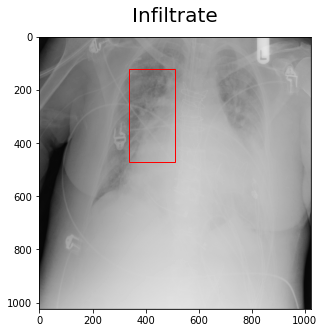

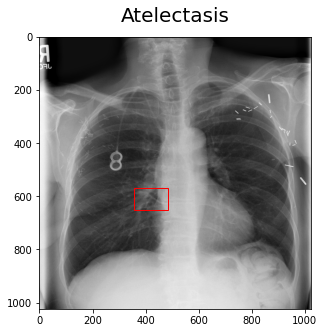

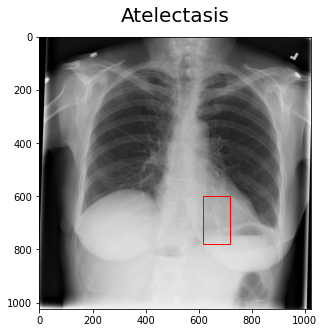

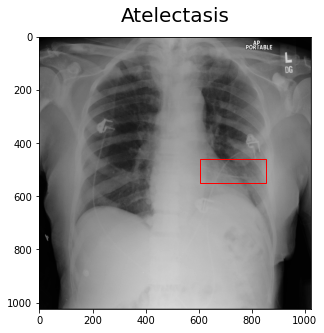

FileNotFoundError: [Errno 2] No such file or directory: 'data/images/images_001/00000001_000.png'

In [20]:
# Display some images. The last 4 images are the 4 channels of one same image. I don't understand why some have 4 channels yet
NUMBER_BBOX = 4
bboxes = bounding_boxes.sort_values("Filename").iloc[:NUMBER_BBOX] #Sort by Filename in case one only downloaded the first folder of data in the dataset
for i in range(NUMBER_BBOX):
    bbox = bboxes.iloc[i]
    img_path = os.path.join("../backend-project/data/images/images/", bbox["Filename"])
    display_image(scale_image(read_image(img_path)), bbox)
    
display_image(scale_image(read_image(os.path.join("data/images/images_001/", data.iloc[0]["Filename"])))) #Display one last image without bbox

#Some images have more than 1 channel for unknown reasons. Here is an example:
image_too_many_channels = scale_image(read_image(os.path.join("data/images/images_001/", "00000083_000.png")))
for i in range(image_too_many_channels.shape[2]):
    display_image(image_too_many_channels[:,:,i])

## AE

In [6]:
class XRayDataset(Dataset):
    '''
    Class to represent our dataset of XRay images. Subclass of torch.utils.data.Dataset. Store the image directory,
    images name, bounding boxes and data of the images we will use either for training or testing.
    '''
    def __init__(self, img_dir, transform=None, train=True):
        '''
        Constructor

        Parameters
        ----------
        img_dir : str
            Directory where the images are stored. Will take all the png files present in this directory
        transform: optional, function
            Transformation used on every image before returning it such as scaling.
        train: optional, Boolean
            If set to true, we keep only the training data in the corresponding folder and otherwise the testing one
        '''
        self.img_dir = img_dir
        # Read all the names of the PNG files in the directory
        images_name = np.array([name for name in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, name)) and re.search('png$', name) is not None])
        data, train_names, test_names, bounding_boxes = load_data(filenames_to_keep = images_name)
        
        # Keep only the training or test ones
        self.data = data[data["Filename"].isin((train_names if train else test_names))]
        self.bounding_boxes = bounding_boxes[bounding_boxes["Filename"].isin((train_names if train else test_names))]
        self.images_name = images_name[np.isin(images_name, (train_names if train else test_names))]
        
        self.transform = transform
        
    def __len__(self):
        '''
        Overload: return the length of the dataset

        Return
        ----------
        length: înt:
            The length of the dataset
        '''
        return self.images_name.shape[0]

    def __getitem__(self, idx):
        '''
        Overload; get the item (only image for the moment) corresponding to the given idx.

        Parameters
        ----------
        idx : int
            Index of the item we want to get.

        Return
        ----------
        image: np.array(X, Y):
            The corresponding image transformed with the transform method
        '''
        img_path = os.path.join(self.img_dir, self.images_name[idx])
        image = read_image(img_path)
        
        if(len(image.shape)>2): #Some images have more than one channel for unknown reasons
            image = image[:, :, 0]

        
        data = self.data[self.data["Filename"]==self.images_name[idx]]
        
        bbox = None
        if not self.bounding_boxes[self.bounding_boxes["Filename"]==self.images_name[idx]].empty:
            bbox = self.bounding_boxes[self.bounding_boxes["Filename"]==self.images_name[idx]]
        
        if self.transform:
            image = self.transform(image)
            if image.shape[0] == 1:
                image=image.squeeze()

        return image#, data, bbox # Cannot pass data and bbox for the moment because they contain entries of type "object" which is a problem for dataloader. Should transform the few entries having object type

In [22]:
class Encoder(nn.Module):
    '''
    An encoder that flattens the image first and then only uses 2 linear layers. Subclass of nn.Module.
    '''

    def __init__(self, image_dimension, encoded_dimension=16):
        '''
        Constructor

        Parameters
        ----------
        image_dimension: Tuple(int, int):
            The image dimension of a single image.
        encoded_dimension: int
            The dimension for the final encoding.
        '''
        super().__init__()

        flat_image_dimension = image_dimension[0] * image_dimension[1]

        self.model = nn.Sequential(
            nn.Linear(in_features=flat_image_dimension, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=encoded_dimension),
            nn.ReLU(),
        )
    
    def forward(self, images):
        """Overload. Encode the image."""
        batch_size = images.shape[0]
        flat_images = images.view(batch_size, -1)
        return self.model(flat_images)


class Decoder(nn.Module):
    '''
    A decoder that only uses linear layers. It's the counterpart to the Encoder. Subclass of nn.Module.
    '''
    def __init__(self, image_dimension, encoded_dimension=16):
        '''
        Constructor

        Parameters
        ----------
        image_dimension: Tuple(int, int):
            The image dimension of a single image.
        encoded_dimension: int
            The dimension for the final encoding.
        '''
        super().__init__()

        self.image_dimension = image_dimension
        flat_image_dimension = image_dimension[0] * image_dimension[1]
    
        self.model = nn.Sequential(
            nn.Linear(in_features=encoded_dimension, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=flat_image_dimension),
            nn.Sigmoid(),
        )
    
    def forward(self, encodings):
        """Overload: Decode the latent representation."""
        batch_size = encodings.shape[0]
        flat_images = self.model(encodings)
        images = flat_images.view(batch_size, *self.image_dimension)
        return images


class AutoEncoder(nn.Module):
    '''
    An auto-encoder model. Subclass of nn.Module.
    '''
    def __init__(self, encoder, decoder):
        '''
        Constructor

        Parameters
        ----------
        encoder: nn.Module
            The encoder
        decoder: nn.Module
            The decoder
        '''
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images):
        """Overload: Decode the latent representation encoded by itself."""
        return self.decoder(self.encoder(images))

In [7]:
def train(autoencoder, train_loader, num_epochs=5, verbose=1):
    '''
    Train the autoencoder.
    
    Parameters
    ----------
    autoencoder: nn.Module
        The autoencoder model.
    train_loader: DataLoader
        A Pytorch Dataloader containing the training images.
    num_epochs: optional, int 
        The number of epochs to train.
    verbose: optional, int
        Set the number of printing we want during training. For the moment, only 0 for no printing or another value
        to get some information about the update.
    
    Return
    ----------
    loss_history: list
        A list of training losses. One for each epoch of training.
    '''
    loss_history = []
    for e in range(num_epochs):
        if verbose:
            print(f"=========== EPOCH {e} ===========")
        total_loss = 0
        number_samples = 0
        for i, batch in enumerate(train_loader):
            #X, data, bbox = batch
            X = batch
            output = autoencoder(X)
            loss = loss_fn(output, X)
            total_loss += loss.detach()
            number_samples += X.shape[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose and not i%100 and not i==0:
                print(f"Done processing batch number {i}")
        
        if verbose:
            print(f"Mean loss = {total_loss/number_samples}")
        
        loss_history.append(total_loss/number_samples)
    return loss_history

def plot_loss(epoch_losses, title='Train Loss'):
    '''
    Very Simple plot for the losses at each epoch.
    
    Parameters
    ----------
    epoch_losses: list
        A list of training losses. One for each epoch of training.
    title: optional, str
        the title of the plot.
    '''
    plt.figure()
    plt.plot(epoch_losses)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.show()

In [8]:
# Compute the dataloader for training and testing using our custom dataset
IMG_DIR = "../backend-project/data/images/images/"
BATCH_SIZE = 2

training_data = XRayDataset(
    img_dir=IMG_DIR,
    train=True,
    transform=ToTensor() #This method directly scale the image in [0, 1] range
)

test_data = XRayDataset(
    img_dir=IMG_DIR,
    train=False,
    transform=ToTensor() #This method directly scale the image in [0, 1] range
)

train_loader = DataLoader(training_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(test_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

In [24]:
# Create our autoencoder and train it
# Parameters
NUM_EPOCHS = 1
LEARNING_RATE = 1e-3

LATENT_SPACE_DIM = 16
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Model
autoencoder = VariationnalAutoEncoder(
    variational_encoder=CNNVariationalEncoder(
        img_dims=training_data[0].shape,
        latent_dim=LATENT_SPACE_DIM,
    ).to(device),
    decoder=Decoder(
        img_dims=training_data[0].shape,
        latent_dim=LATENT_SPACE_DIM,
    ).to(device)
)

# Loss function & optimizer
loss_fn = nn.MSELoss() # Mean squared error
optimizer = optim.Adam(autoencoder.parameters(),
                       lr=LEARNING_RATE)


epoch_losses = train(autoencoder, train_loader, num_epochs=NUM_EPOCHS)
plot_loss(epoch_losses, 'Training Loss - Simple Model')

=========== EPOCH 0 ===========


KeyboardInterrupt: 

## VAE

In [12]:
class VariationalEncoder(nn.Module):
    def __init__(self, img_dims, latent_dim):
        super().__init__()

        flat_img_dim = img_dims[0] * img_dims[1]

        self.encoder = nn.Sequential(
            nn.Linear(flat_img_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_var = nn.Linear(32, latent_dim)
        
    
    def forward(self, input: Tensor, **kwargs) -> [Tensor]:
        
        batch_size = input.shape[0]
        flat_images = input.view(batch_size, -1)
        
        encoded_result = self.encoder(flat_images)
        mu = self.fc_mu(encoded_result)
        log_var = self.fc_var(encoded_result)
        
        # sample z
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z

In [13]:
class Decoder(nn.Module):
    def __init__(self, img_dims, latent_dim):
        super().__init__()

        self.img_dims = img_dims
        flat_img_dimension = img_dims[0] * img_dims[1]
    
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, flat_img_dimension),
            nn.Sigmoid(),
        )
    
    def forward(self, input: Tensor, **kwargs) -> [Tensor]:
        
        batch_size = input.shape[0]
        
        flat_images = self.decoder(input)
        
        images = flat_images.view(batch_size, *self.img_dims)
        
        return images

In [14]:
class VariationnalAutoEncoder(nn.Module):
    def __init__(self, variational_encoder, decoder):
        super().__init__()
        
        self.variational_encoder = variational_encoder
        self.decoder = decoder
        
    def forward(self, input: Tensor, **kwargs) -> [Tensor]:
        return self.decoder(self.variational_encoder(input))
    
    def loss_function(self, *args, **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

In [23]:
class CNNVariationalEncoder(nn.Module):
    def __init__(self, img_dims, latent_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(2,16, 5),
            nn.ReLU(),
            nn.Conv2d(16, 2, 5),
            nn.Flatten(),
            nn.Linear(1032256, 32),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_var = nn.Linear(32, latent_dim)
        
    
    def forward(self, input: Tensor, **kwargs) -> [Tensor]:
        
        #print(input.shape)
        batch_size = input.shape[0]
        #flat_images = input.view(batch_size, -1)
        
        encoded_result = self.encoder(input)
        mu = self.fc_mu(encoded_result)
        log_var = self.fc_var(encoded_result)
        
        # sample z
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z